# Prediksi Harga Beras menggunakan AdaBoost Regressor
## Dataset From : https://www.bi.go.id/hargapangan

# IMPORT LIBRARY

In [ ]:
import pandas as pd # Pandas untuk mengelola Dataset
from sklearn.ensemble import AdaBoostRegressor # Mengimport metode AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor # Mengimport Decision Tree Regressor
from sklearn.metrics import mean_absolute_error, mean_squared_error # Library untuk Metrik Evaluasi
from datetime import datetime # Mengimport tipe datetime untuk tipe data waktu (Date)
import matplotlib.pyplot as plt # Matplotlib.pyplot untuk visualisasi data
from sklearn.model_selection import train_test_split # train_test_split untuk pembagian data training dan testing
from sklearn.preprocessing import StandardScaler # Untuk standarisasi Data agar skalanya dapat sesuai
from matplotlib.dates import DateFormatter # Library untuk mengubah Visual Data menjadi bentuk format Date(Tanggal)

In [ ]:
Data_Beras = pd.read_excel("Harga Beras 2023-2024.xlsx") # Membaca Dataset dari Excel
print(Data_Beras) # Menampilkan Dataset

         Tanggal     Provinsi        Jenis Pasar   Harga
0     2023-05-01         Aceh  Pasar Tradisional     NaN
1     2023-05-02         Aceh  Pasar Tradisional  11,800
2     2023-05-03         Aceh  Pasar Tradisional  11,700
3     2023-05-04         Aceh  Pasar Tradisional  11,700
4     2023-05-05         Aceh  Pasar Tradisional  11,700
...          ...          ...                ...     ...
35103 2024-04-24  Papua Barat           Produsen  12,750
35104 2024-04-25  Papua Barat           Produsen  13,250
35105 2024-04-26  Papua Barat           Produsen  13,250
35106 2024-04-29  Papua Barat           Produsen  13,250
35107 2024-04-30  Papua Barat           Produsen  13,250

[35108 rows x 4 columns]


# Preprocessing
### Penghapusan Nilai NULL

In [ ]:
# Memeriksa nilai NULL
Data_Beras.isnull().sum() #isnull() untuk memeriksa nilai NULL/kosong sedangkan sum untuk menjumlahkan nilai baris yang NULL/kosong tersebut

Tanggal          0
Provinsi         0
Jenis Pasar      0
Harga          715
dtype: int64

In [ ]:
# Proses menghapus nilai NULL
Data_Beras.dropna(inplace=True) # dropna() untuk menghapus NULL. inplace=True berarti proses penghapusan dilakukan langsung pada Dataframe tersebut
Data_Beras.reset_index(drop=True, inplace=True) # reset_index untuk mereset indeks dari data yang tersisa setelah proses penghapusan data NULL
#drop=True berarti indeks yang lama akan dihapus.

In [ ]:
Data_Beras.isnull().sum() # Memeriksa kembali nilai NULL

Tanggal        0
Provinsi       0
Jenis Pasar    0
Harga          0
dtype: int64

In [ ]:
Data_Beras.info() # Menampilkan Informasi Kolom dari dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34393 entries, 0 to 34392
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Tanggal      34393 non-null  datetime64[ns]
 1   Provinsi     34393 non-null  object        
 2   Jenis Pasar  34393 non-null  object        
 3   Harga        34393 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.0+ MB


### Transformasi Data
#### Menghapus karakter Koma dalam setiap baris pada kolom Harga

In [ ]:
# Menghapus karakter koma(,) dalam setiap baris pada kolom Harga, agar bisa diubah menjadi float
Data_Beras['Harga'] = Data_Beras['Harga'].str.replace(',','') # str.replace untuk mengganti karakter koma dengan kosong (menghapus koma)
# Mengubah Tipe Data kolom Harga menjadi float
Data_Beras['Harga'] = Data_Beras['Harga'].astype('float64') # astype untuk mengubah tipe data menjadi float

In [ ]:
Data_Beras.head(5) #Menampilkan 5 data teratas

,Tanggal,Provinsi,Jenis Pasar,Harga
0,2023-05-02,Aceh,Pasar Tradisional,11800.0
1,2023-05-03,Aceh,Pasar Tradisional,11700.0
2,2023-05-04,Aceh,Pasar Tradisional,11700.0
3,2023-05-05,Aceh,Pasar Tradisional,11700.0
4,2023-05-08,Aceh,Pasar Tradisional,11700.0


### Mengubah Representasi Provinsi dan Jenis Pasar yang merupakan kategori menjadi angka

In [ ]:
# Mengubah Representasi Kolom Provinsi dan Jenis Pasar menjadi angka
# Dictionary 34 Provinsi untuk Kategori
Dictionary_Provinsi = {
    'Aceh': 0,
    'Sumatera Utara': 1,
    'Sumatera Barat': 2,
    'Riau': 3,
    'Kepulauan Riau': 4,
    'Jambi': 5,
    'Bengkulu': 6,
    'Sumatera Selatan': 7,
    'Kepulauan Bangka Belitung': 8,
    'Lampung': 9,
    'Banten': 10,
    'Jawa Barat': 11,
    'DKI Jakarta': 12,
    'Jawa Tengah': 13,
    'DI Yogyakarta': 14,
    'Jawa Timur': 15,
    'Bali': 16,
    'Nusa Tenggara Barat': 17,
    'Nusa Tenggara Timur': 18,
    'Kalimantan Barat': 19,
    'Kalimantan Selatan': 20,
    'Kalimantan Tengah': 21,
    'Kalimantan Timur': 22,
    'Kalimantan Utara': 23,
    'Gorontalo': 24,
    'Sulawesi Selatan': 25,
    'Sulawesi Tenggara': 26,
    'Sulawesi Tengah': 27,
    'Sulawesi Utara': 28,
    'Sulawesi Barat': 29,
    'Maluku': 30,
    'Maluku Utara': 31,
    'Papua': 32,
    'Papua Barat': 33
}

# Dictionary 4 Jenis Pasar untuk Kategori
Dictionary_Jenis_Pasar = {
    'Pasar Tradisional': 0,
    'Pasar Modern': 1,
    'Pedagang Besar': 2,
    'Produsen': 3
}

# Ganti nilai Provinsi dan Jenis pasar sesuai Dictionary
Data_Beras['Provinsi'] = Data_Beras['Provinsi'].map(Dictionary_Provinsi) # Fungsi map untuk memetakan semua key sesuai valuenya
Data_Beras['Jenis Pasar'] = Data_Beras['Jenis Pasar'].map(Dictionary_Jenis_Pasar) # Fungsi map untuk memetakan semua key sesuai valuenya

In [ ]:
Data_Beras.info() # Menampilkan Informasi setiap kolom dalam DataFrame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34393 entries, 0 to 34392
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Tanggal      34393 non-null  datetime64[ns]
 1   Provinsi     34393 non-null  int64         
 2   Jenis Pasar  34393 non-null  int64         
 3   Harga        34393 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 1.0 MB


In [ ]:
Data_Beras.head(5) # Menampilkan Data Beras 5 teratas

,Tanggal,Provinsi,Jenis Pasar,Harga
0,2023-05-02,0,0,11800.0
1,2023-05-03,0,0,11700.0
2,2023-05-04,0,0,11700.0
3,2023-05-05,0,0,11700.0
4,2023-05-08,0,0,11700.0


## Memecah Tanggal menjadi Tanggal(Day), Bulan(Month), Tahun(Year)

In [ ]:
# Konversi kolom Tanggal menjadi format datetime menggunakan pandas
Data_Beras['Tanggal'] = pd.to_datetime(Data_Beras['Tanggal'])

# Memecah Tanggal menjadi Tanggal, Bulan dan Tahun
Data_Beras['Tahun'] = Data_Beras['Tanggal'].dt.year
Data_Beras['Bulan'] = Data_Beras['Tanggal'].dt.month
Data_Beras['Tanggal'] = Data_Beras['Tanggal'].dt.day

# Mengatur Urutan Kolom
Data_Beras = Data_Beras[['Tanggal', 'Bulan', 'Tahun', 'Provinsi', 'Jenis Pasar', 'Harga']]

In [ ]:
Data_Beras.head(5) # Menampilkan Data Beras 5 teratas

,Tanggal,Bulan,Tahun,Provinsi,Jenis Pasar,Harga
0,2,5,2023,0,0,11800.0
1,3,5,2023,0,0,11700.0
2,4,5,2023,0,0,11700.0
3,5,5,2023,0,0,11700.0
4,8,5,2023,0,0,11700.0


# Splitting Data
### 1. Train=90%, Test=10%
### 2. Train=80%, Test=20%
### 3. Train=70%, Test=30%
### 4. Train=60%, Test=40%

In [ ]:
#1. Membagi data menjadi Train dan Test perbandingan Train = 90% dan Test = 10% dan Random State(Pengacakan dataset) = 253
X_train_90, X_test_10, Y_train_90, Y_test_10 = train_test_split(Data_Beras[['Tanggal', 'Bulan', 'Tahun', 'Provinsi', 'Jenis Pasar']], Data_Beras['Harga'], test_size=0.1, random_state=253)

#2. Membagi data menjadi Train dan Test perbandingan Train = 80% dan Test = 20% dan Random State(Pengacakan dataset) = 253
X_train_80, X_test_20, Y_train_80, Y_test_20 = train_test_split(Data_Beras[['Tanggal', 'Bulan', 'Tahun', 'Provinsi', 'Jenis Pasar']], Data_Beras['Harga'], test_size=0.2, random_state=253)

#3. Membagi data menjadi Train dan Test perbandingan Train = 70% dan Test = 30% dan Random State(Pengacakan dataset) = 253
X_train_70, X_test_30, Y_train_70, Y_test_30 = train_test_split(Data_Beras[['Tanggal', 'Bulan', 'Tahun', 'Provinsi', 'Jenis Pasar']], Data_Beras['Harga'], test_size=0.3, random_state=253)

#4. Membagi data menjadi Train dan Test perbandingan Train = 60% dan Test = 40% dan Random State(Pengacakan dataset) = 253
X_train_60, X_test_40, Y_train_60, Y_test_40 = train_test_split(Data_Beras[['Tanggal', 'Bulan', 'Tahun', 'Provinsi', 'Jenis Pasar']], Data_Beras['Harga'], test_size=0.4, random_state=253)

# Membuat Model dan Evaluasi Model menggunakan R^2
## Skema Model
### 1. AdaBoostRegressor(estimator=None, n_estimators=50, learning_rate=1)
### 2. AdaBoostRegressor(estimator=None, n_estimators=50, learning_rate=0.1)
### 3. AdaBoostRegressor(estimator=None, n_estimators=100, learning_rate=1)
### 4. AdaBoostRegressor(estimator=None, n_estimators=100, learning_rate=0.1)
### 5. AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, learning_rate=1)
### 6. AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, learning_rate=0.1)
### 7. AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, learning_rate=1)
### 8. AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, learning_rate=0.1)
## Model Skema 1

In [ ]:
# Model Skema 1
model_1 = AdaBoostRegressor(estimator=None, n_estimators=50, learning_rate=1, random_state=253)

#Training Model
model_1.fit(X_train_90, Y_train_90) # Training model 1 skema 90:10
score_90_10 = model_1.score(X_test_10, Y_test_10) # Hitung R Square Model 1 skema 90:10
print("R^2 Model 1 (90:10) =",score_90_10) # Menampilkan R Square Model 1 skema 90:10

model_1.fit(X_train_80, Y_train_80) # Training model 1 skema 80:20
score_80_20 = model_1.score(X_test_20, Y_test_20) # Hitung R Square Model 1 skema 80:20
print("R^2 Model 1 (80:20) =",score_80_20) # Menampilkan R Square Model 1 skema 80:20

model_1.fit(X_train_70, Y_train_70) # Training model 1 skema 70:30
score_70_30 = model_1.score(X_test_30, Y_test_30) # Hitung R Square Model 1 skema 70:30
print("R^2 Model 1 (70:30) =",score_70_30) # Menampilkan R Square Model 1 skema 70:30

model_1.fit(X_train_60, Y_train_60) # Training model 1 skema 60:40
score_60_40 = model_1.score(X_test_40, Y_test_40) # Hitung R Square Model 1 skema 60:40
print("R^2 Model 1 (60:40) =",score_60_40) # Menampilkan R Square Model 1 skema 60:40

R^2 Model 1 (90:10) = 0.6137648888285205
R^2 Model 1 (80:20) = 0.6125032821818664
R^2 Model 1 (70:30) = 0.5939921447457782
R^2 Model 1 (60:40) = 0.5960434981832228


## Model Skema 2

In [ ]:
# Model Skema 2
model_2 = AdaBoostRegressor(estimator=None, n_estimators=50, learning_rate=0.1, random_state=253) #random_state ini untuk mengatur random seed agar selalu 42

#Training Model
model_2.fit(X_train_90, Y_train_90) # Training Model 2 skema 90:10
score_90_10 = model_2.score(X_test_10, Y_test_10) # Hitung R Square Model 2 skema 90:10
print("R^2 Model 2 (90:10) =",score_90_10) # Menampilkan R Square Model 2 skema 90:10

model_2.fit(X_train_80, Y_train_80) # Training Model 2 skema 80:20
score_80_20 = model_2.score(X_test_20, Y_test_20) # Hitung R Square Model 2 skema 80:20
print("R^2 Model 2 (80:20) =",score_80_20) # Menampilkan R Square Model 2 skema 80:20

model_2.fit(X_train_70, Y_train_70) # Training Model 2 skema 70:30
score_70_30 = model_2.score(X_test_30, Y_test_30) # Hitung R Square Model 2 skema 70:30
print("R^2 Model 2 (70:30) =",score_70_30) # Menampilkan R Square Model 2 skema 70:30

model_2.fit(X_train_60, Y_train_60) # Training Model 2 skema 60:40
score_60_40 = model_2.score(X_test_40, Y_test_40) # Hitung R Square Model 2 skema 60:40
print("R^2 Model 2 (60:40) =",score_60_40) # Menampilkan R Square Model 2 skema 60:40

R^2 Model 2 (90:10) = 0.49085627760707695
R^2 Model 2 (80:20) = 0.47730106305920306
R^2 Model 2 (70:30) = 0.47189864381434377
R^2 Model 2 (60:40) = 0.472929969130899


## Model Skema 3

In [ ]:
# Model Skema 3
model_3 = AdaBoostRegressor(estimator=None, n_estimators=100, learning_rate=1, random_state=253) #random_state ini untuk mengatur random seed agar selalu 42

#Training Model
model_3.fit(X_train_90, Y_train_90) # Training Model 3 skema 90:10
score_90_10 = model_3.score(X_test_10, Y_test_10) # Hitung R Square Model 3 skema 90:10
print("R^2 Model 3 (90:10) =",score_90_10) # Menampilkan R Square Model 3 skema 90:10

model_3.fit(X_train_80, Y_train_80) # Training Model 3 skema 80:20
score_80_20 = model_3.score(X_test_20, Y_test_20) # Hitung R Square Model 3 skema 80:20
print("R^2 Model 3 (80:20) =",score_80_20) # Menampilkan R Square Model 3 skema 80:20

model_3.fit(X_train_70, Y_train_70) # Training Model 3 skema 70:30
score_70_30 = model_3.score(X_test_30, Y_test_30) # Hitung R Square Model 3 skema 70:30
print("R^2 Model 3 (70:30) =",score_70_30) # Menampilkan R Square Model 3 skema 70:30

model_3.fit(X_train_60, Y_train_60) # Training Model 3 skema 60:40
score_60_40 = model_3.score(X_test_40, Y_test_40) # Hitung R Square Model 3 skema 60:40
print("R^2 Model 3 (60:40) =",score_60_40) # Menampilkan R Square Model 3 skema 60:40

R^2 Model 3 (90:10) = 0.6229256656941082
R^2 Model 3 (80:20) = 0.5977857904265328
R^2 Model 3 (70:30) = 0.6062492713611197
R^2 Model 3 (60:40) = 0.5960434981832228


## Model Skema 4

In [ ]:
# Model Skema 4
model_4 = AdaBoostRegressor(estimator=None, n_estimators=100, learning_rate=0.1, random_state=253) #random_state ini untuk mengatur random seed agar selalu 42

#Training Model
model_4.fit(X_train_90, Y_train_90) # Training Model 4 skema 90:10
score_90_10 = model_4.score(X_test_10, Y_test_10) # Hitung R Square Model 4 skema 90:10
print("R^2 Model 4 (90:10) =",score_90_10) # Menampilkan R Square Model 4 skema 90:10

model_4.fit(X_train_80, Y_train_80) # Training Model 4 skema 80:20
score_80_20 = model_4.score(X_test_20, Y_test_20) # Hitung R Square Model 4 skema 80:20
print("R^2 Model 4 (80:20) =",score_80_20) # Menampilkan R Square Model 4 skema 80:20

model_4.fit(X_train_70, Y_train_70) # Training Model 4 skema 70:30
score_70_30 = model_4.score(X_test_30, Y_test_30) # Hitung R Square Model 4 skema 70:30
print("R^2 Model 4 (70:30) =",score_70_30) # Menampilkan R Square Model 4 skema 70:30

model_4.fit(X_train_60, Y_train_60) # Training Model 4 skema 60:40
score_60_40 = model_4.score(X_test_40, Y_test_40) # Hitung R Square Model 4 skema 60:40
print("R^2 Model 4 (60:40) =",score_60_40) # Menampilkan R Square Model 4 skema 60:40

R^2 Model 4 (90:10) = 0.519457464928273
R^2 Model 4 (80:20) = 0.4996007728766714
R^2 Model 4 (70:30) = 0.5067991907085583
R^2 Model 4 (60:40) = 0.5078480572759513


## Model Skema 5

In [ ]:
# Model Skema 5
model_5 = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, learning_rate=1, random_state=253) #random_state ini untuk mengatur random seed agar selalu 42

#Training Model
model_5.fit(X_train_90, Y_train_90) # Training Model 5 skema 90:10
score_90_10 = model_5.score(X_test_10, Y_test_10) # Hitung R Square Model 5 skema 90:10
print("R^2 Model 5 (90:10) =",score_90_10) # Menampilkan R Square Model 5 skema 90:10

model_5.fit(X_train_80, Y_train_80) # Training Model 5 skema 80:20
score_80_20 = model_5.score(X_test_20, Y_test_20) # Hitung R Square Model 5 skema 80:20
print("R^2 Model 5 (80:20) =",score_80_20) # Menampilkan R Square Model 5 skema 80:20

model_5.fit(X_train_70, Y_train_70) # Training Model 5 skema 70:30
score_70_30 = model_5.score(X_test_30, Y_test_30) # Hitung R Square Model 5 skema 70:30
print("R^2 Model 5 (70:30) =",score_70_30) # Menampilkan R Square Model 5 skema 70:30

model_5.fit(X_train_60, Y_train_60) # Training Model 5 skema 60:40
score_60_40 = model_5.score(X_test_40, Y_test_40) # Hitung R Square Model 5 skema 60:40
print("R^2 Model 5 (60:40) =",score_60_40) # Menampilkan R Square Model 5 skema 60:40

R^2 Model 5 (90:10) = 0.9972193841400517
R^2 Model 5 (80:20) = 0.9961826649826577
R^2 Model 5 (70:30) = 0.9958192008009649
R^2 Model 5 (60:40) = 0.995843455310729


## Model Skema 6

In [ ]:
# Model Skema 6
model_6 = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=50, learning_rate=0.1, random_state=253) #random_state ini untuk mengatur random seed agar selalu 42

#Training Model
model_6.fit(X_train_90, Y_train_90) # Training Model 6 skema 90:10
score_90_10 = model_6.score(X_test_10, Y_test_10) # Hitung R Square Model 6 skema 90:10
print("R^2 Model 6 (90:10) =",score_90_10) # Menampilkan R Square Model 6 skema 90:10

model_6.fit(X_train_80, Y_train_80) # Training Model 6 skema 80:20
score_80_20 = model_6.score(X_test_20, Y_test_20) # Hitung R Square Model 6 skema 80:20
print("R^2 Model 6 (80:20) =",score_80_20) # Menampilkan R Square Model 6 skema 80:20

model_6.fit(X_train_70, Y_train_70) # Training Model 6 skema 70:30
score_70_30 = model_6.score(X_test_30, Y_test_30) # Hitung R Square Model 6 skema 70:30
print("R^2 Model 6 (70:30) =",score_70_30) # Menampilkan R Square Model 6 skema 70:30

model_6.fit(X_train_60, Y_train_60) # Training Model 6 skema 60:40
score_60_40 = model_6.score(X_test_40, Y_test_40) # Hitung R Square Model 6 skema 60:40
print("R^2 Model 6 (60:40) =",score_60_40) # Menampilkan R Square Model 6 skema 60:40

R^2 Model 6 (90:10) = 0.9968871312850797
R^2 Model 6 (80:20) = 0.9952391035469077
R^2 Model 6 (70:30) = 0.995402612485666
R^2 Model 6 (60:40) = 0.9951232457111351


## Model Skema 7

In [ ]:
# Model Skema 7
model_7 = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, learning_rate=1, random_state=253) #random_state ini untuk mengatur random seed agar selalu 42

#Training Model
model_7.fit(X_train_90, Y_train_90) # Training Model 7 skema 90:10
score_90_10 = model_7.score(X_test_10, Y_test_10) # Hitung R Square Model 7 skema 90:10
print("R^2 Model 7 (90:10) =",score_90_10) # Menampilkan R Square Model 7 skema 90:10

model_7.fit(X_train_80, Y_train_80) # Training Model 7 skema 80:20
score_80_20 = model_7.score(X_test_20, Y_test_20) # Hitung R Square Model 7 skema 80:20
print("R^2 Model 7 (80:20) =",score_80_20) # Menampilkan R Square Model 7 skema 80:20

model_7.fit(X_train_70, Y_train_70) # Training Model 7 skema 70:30
score_70_30 = model_7.score(X_test_30, Y_test_30) # Hitung R Square Model 7 skema 70:30
print("R^2 Model 7 (70:30) =",score_70_30) # Menampilkan R Square Model 7 skema 70:30

model_7.fit(X_train_60, Y_train_60) # Training Model 7 skema 60:40
score_60_40 = model_7.score(X_test_40, Y_test_40) # Hitung R Square Model 7 skema 60:40
print("R^2 Model 7 (60:40) =",score_60_40) # Menampilkan R Square Model 7 skema 60:40

R^2 Model 7 (90:10) = 0.9969986798890205
R^2 Model 7 (80:20) = 0.9963049073805188
R^2 Model 7 (70:30) = 0.9962144448160641
R^2 Model 7 (60:40) = 0.9958419141373182


## Model Skema 8

In [ ]:
# Model Skema 8
model_8 = AdaBoostRegressor(estimator=DecisionTreeRegressor(), n_estimators=100, learning_rate=0.1, random_state=253) #random_state ini untuk mengatur random seed agar selalu 42

#Training Model
model_8.fit(X_train_90, Y_train_90) # Training Model 8 skema 90:10
score_90_10 = model_8.score(X_test_10, Y_test_10) # Hitung R Square Model 8 skema 90:10
print("R^2 Model 8 (90:10) =",score_90_10) # Menampilkan R Square Model 8 skema 90:10

model_8.fit(X_train_80, Y_train_80) # Training Model 8 skema 80:20
score_80_20 = model_8.score(X_test_20, Y_test_20) # Hitung R Square Model 8 skema 80:20
print("R^2 Model 8 (80:20) =",score_80_20) # Menampilkan R Square Model 8 skema 80:20

model_8.fit(X_train_70, Y_train_70) # Training Model 8 skema 70:30
score_70_30 = model_8.score(X_test_30, Y_test_30) # Hitung R Square Model 8 skema 70:30
print("R^2 Model 8 (70:30) =",score_70_30) # Menampilkan R Square Model 8 skema 70:30

model_8.fit(X_train_60, Y_train_60) # Training Model 8 skema 60:40
score_60_40 = model_8.score(X_test_40, Y_test_40) # Hitung R Square Model 8 skema 60:40
print("R^2 Model 8 (60:40) =",score_60_40) # Menampilkan R Square Model 8 skema 60:40

R^2 Model 8 (90:10) = 0.9965596643438082
R^2 Model 8 (80:20) = 0.9953683713699331
R^2 Model 8 (70:30) = 0.9955924020087856
R^2 Model 8 (60:40) = 0.9950239363494684


# PREDIKSI HARGA BERAS SELAMA SEBULAN (1 Mei 2024 - 31 Mei 2024) Menggunakan Model terbaik yaitu Model Skema 5 (90:10)

In [ ]:
# Training Kembali Model 5 dengan dataset 90:10
model_5.fit(X_train_90, Y_train_90)

AdaBoostRegressor(estimator=DecisionTreeRegressor(), learning_rate=1,
                  random_state=253)

## Membuat DataFrame sebagai Input Data

In [ ]:
Data_Provinsi_Unik = Data_Beras['Provinsi'].unique() # Mengambil nama setiap Provinsi tanpa duplikasi
Data_Jenis_Pasar_Unik = Data_Beras['Jenis Pasar'].unique() # Mengambil nama setiap Jenis Pasar tanpa duplikasi
Tanggal_Awal_Prediksi = datetime(2024, 5, 1) # Membuat Batas Tanggal awal Prediksi
Tanggal_Akhir_Prediksi = datetime(2024, 5, 31) # Membuat Batas Tanggal akhir Prediksi
Tanggal_Prediksi = pd.date_range(Tanggal_Awal_Prediksi, Tanggal_Akhir_Prediksi) # Membuat Range tanggal awal sampai tanggal akhir

Input_Data = pd.DataFrame(columns=['Tanggal', 'Bulan', 'Tahun', 'Provinsi', 'Jenis Pasar'])

# Nested Loop untuk membuat prediksi Harga Beras 1 Bulan Kedepan (1 Mei 2024 - 31 Mei 2024) pada setiap Provinsi dan Jenis Pasar
for Pasar in Data_Jenis_Pasar_Unik:
  for Provinsi in Data_Provinsi_Unik:
    for Tanggal in Tanggal_Prediksi:
      Input_Data = pd.concat([Input_Data, pd.DataFrame({
          'Tanggal': [Tanggal.day],
          'Bulan': [Tanggal.month],
          'Tahun': [Tanggal.year],
          'Provinsi': [Provinsi],
          'Jenis Pasar': [Pasar]
      })], ignore_index=True)

# Copy Input Data untuk menyimpan Hasil Prediksi
Hasil_Prediksi = Input_Data.copy()

In [ ]:
Input_Data # Menampilkan Input Data

,Tanggal,Bulan,Tahun,Provinsi,Jenis Pasar
0,1,5,2024,0,0
1,2,5,2024,0,0
2,3,5,2024,0,0
3,4,5,2024,0,0
4,5,5,2024,0,0
...,...,...,...,...,...
4211,27,5,2024,33,3
4212,28,5,2024,33,3
4213,29,5,2024,33,3
4214,30,5,2024,33,3


In [ ]:
# Menggunakan DataFrame 1 Bulan kedepan yang telah dibuat untuk digunakan sebagai Data Input Model
Prediksi = model_5.predict(Input_Data)
# Memasukkan Hasil Prediksi Ke dalam DataFrame
Hasil_Prediksi['Prediksi'] = Prediksi

In [ ]:
Hasil_Prediksi

,Tanggal,Bulan,Tahun,Provinsi,Jenis Pasar,Prediksi
0,1,5,2024,0,0,13800.0
1,2,5,2024,0,0,13700.0
2,3,5,2024,0,0,13800.0
3,4,5,2024,0,0,13800.0
4,5,5,2024,0,0,13800.0
...,...,...,...,...,...,...
4211,27,5,2024,33,3,12750.0
4212,28,5,2024,33,3,12750.0
4213,29,5,2024,33,3,12750.0
4214,30,5,2024,33,3,13250.0


In [ ]:
# Menggabungkan kembali tanggal, bulan, dan tahun
Hasil_Prediksi['Tanggal'] = pd.to_datetime(Hasil_Prediksi['Tanggal'].astype(str) + '-' + Hasil_Prediksi['Bulan'].astype(str) + '-' + Hasil_Prediksi['Tahun'].astype(str), format='%d-%m-%Y')

# Menghapus kolom Bulan dan Tahun
Hasil_Prediksi = Hasil_Prediksi.drop(['Bulan', 'Tahun'], axis=1)

# Mengatur urutan kolom
Hasil_Prediksi = Hasil_Prediksi[['Tanggal', 'Provinsi', 'Jenis Pasar', 'Prediksi']]

In [ ]:
# Mengembalikan Nama Provinsi dan Jenis Pasar berdasarkan Dictionary
# Mengembalikan nama Provinsi
Hasil_Prediksi['Provinsi'] = Hasil_Prediksi['Provinsi'].map(dict(zip(Dictionary_Provinsi.values(), Dictionary_Provinsi.keys())))

# Mengembalikan jenis pasar
Hasil_Prediksi['Jenis Pasar'] = Hasil_Prediksi['Jenis Pasar'].map(dict(zip(Dictionary_Jenis_Pasar.values(), Dictionary_Jenis_Pasar.keys())))

In [ ]:
Hasil_Prediksi.to_excel("Hasil Prediksi.xlsx", index=False) # Menyimpan Hasil prediksi ke dalam excel tanpa kolom index

## Visualisasi hasil prediksi salah satu Provinsi (Kalimantan Timur)

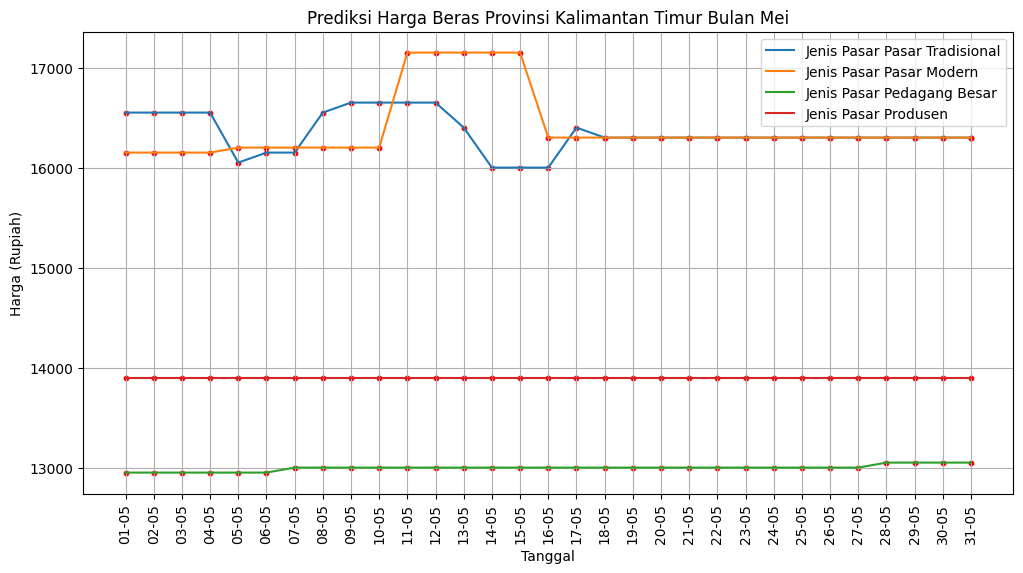

In [ ]:
plt.figure(figsize=(12, 6)) # Untuk membuat ukuran grafik yang ditampilkan
# Perulangan untuk menampilkan hasil prediksi pada seluruh Jenis Pasar
for Jenis_Pasar in Hasil_Prediksi['Jenis Pasar'].unique():
    # Memilih Provinsi yang akan ditampilkan
    Data_Filter = Hasil_Prediksi[(Hasil_Prediksi['Provinsi'] == 'Kalimantan Timur') & (Hasil_Prediksi['Jenis Pasar'] == Jenis_Pasar)]
    # Membuat Grafik garis (plot)
    plt.plot(Data_Filter['Tanggal'], Data_Filter['Prediksi'], label=f'Jenis Pasar {Jenis_Pasar}')
    # Membuat Grafik persebaran titik (Scatter)
    plt.scatter(Data_Filter['Tanggal'], Data_Filter['Prediksi'], s=10, color='red')
# Atur format pencatatan label tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(DateFormatter('%d-%m'))

# Atur interval pencatatan label tanggal pada sumbu x
plt.xticks(Data_Filter['Tanggal'][::1])
plt.xticks(rotation=90)

plt.grid(True)
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rupiah)')
plt.title('Prediksi Harga Beras Provinsi Kalimantan Timur Bulan Mei')
plt.legend() # Menampilkan legenda
plt.show()

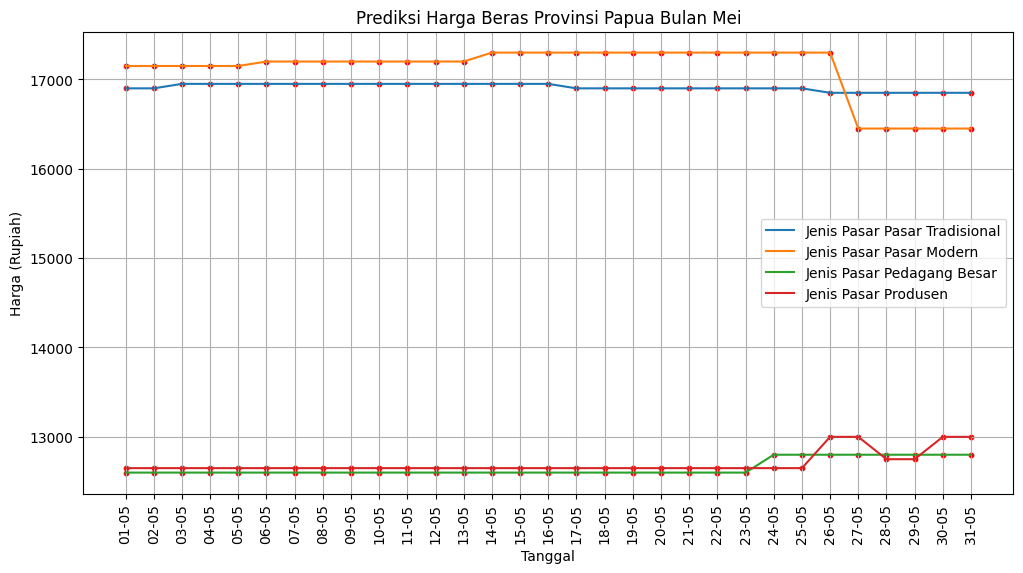

In [ ]:
plt.figure(figsize=(12, 6)) # Untuk membuat ukuran grafik yang ditampilkan
# Perulangan untuk menampilkan hasil prediksi pada seluruh Jenis Pasar
for Jenis_Pasar in Hasil_Prediksi['Jenis Pasar'].unique():
    # Memilih Provinsi yang akan ditampilkan
    Data_Filter = Hasil_Prediksi[(Hasil_Prediksi['Provinsi'] == 'Papua') & (Hasil_Prediksi['Jenis Pasar'] == Jenis_Pasar)]
    # Membuat Grafik garis (plot)
    plt.plot(Data_Filter['Tanggal'], Data_Filter['Prediksi'], label=f'Jenis Pasar {Jenis_Pasar}')
    # Membuat Grafik persebaran titik (Scatter)
    plt.scatter(Data_Filter['Tanggal'], Data_Filter['Prediksi'], s=10, color='red')
# Atur format pencatatan label tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(DateFormatter('%d-%m'))

# Atur interval pencatatan label tanggal pada sumbu x
plt.xticks(Data_Filter['Tanggal'][::1])
plt.xticks(rotation=90)

plt.grid(True)
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rupiah)')
plt.title('Prediksi Harga Beras Provinsi Papua Bulan Mei')
plt.legend() # Menampilkan legenda
plt.show()

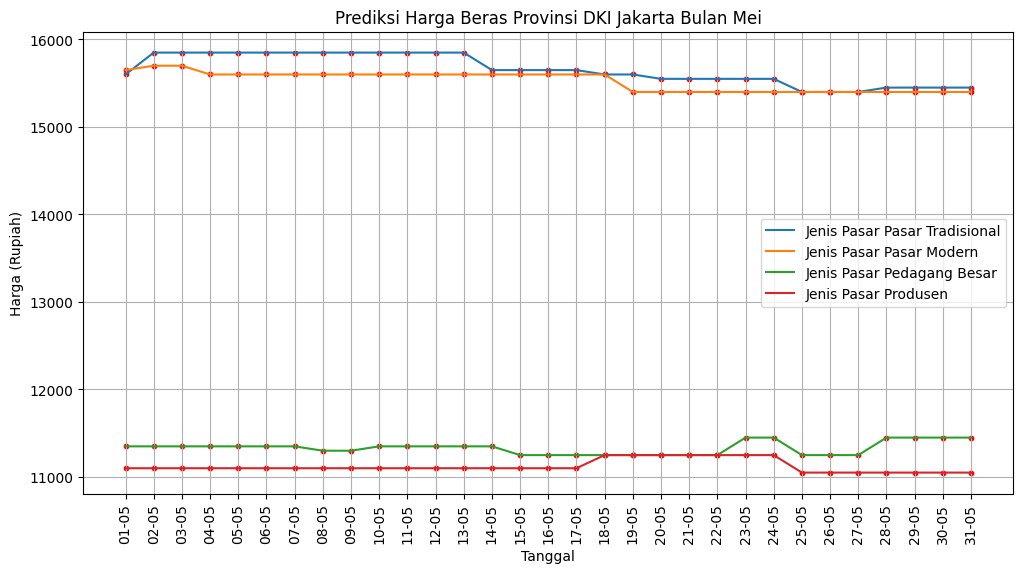

In [ ]:
plt.figure(figsize=(12, 6)) # Untuk membuat ukuran grafik yang ditampilkan
# Perulangan untuk menampilkan hasil prediksi pada seluruh Jenis Pasar
for Jenis_Pasar in Hasil_Prediksi['Jenis Pasar'].unique():
    # Memilih Provinsi yang akan ditampilkan
    Data_Filter = Hasil_Prediksi[(Hasil_Prediksi['Provinsi'] == 'DKI Jakarta') & (Hasil_Prediksi['Jenis Pasar'] == Jenis_Pasar)]
    # Membuat Grafik garis (plot)
    plt.plot(Data_Filter['Tanggal'], Data_Filter['Prediksi'], label=f'Jenis Pasar {Jenis_Pasar}')
    # Membuat Grafik persebaran titik (Scatter)
    plt.scatter(Data_Filter['Tanggal'], Data_Filter['Prediksi'], s=10, color='red')
# Atur format pencatatan label tanggal pada sumbu x
plt.gca().xaxis.set_major_formatter(DateFormatter('%d-%m'))

# Atur interval pencatatan label tanggal pada sumbu x
plt.xticks(Data_Filter['Tanggal'][::1])
plt.xticks(rotation=90)

plt.grid(True)
plt.xlabel('Tanggal')
plt.ylabel('Harga (Rupiah)')
plt.title('Prediksi Harga Beras Provinsi DKI Jakarta Bulan Mei')
plt.legend() # Menampilkan legenda
plt.show()